# Nika Emami - ne2213 - IVP CA3

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Problem 1: Gaussian and Laplacian pyramids

#### a) function to generate J-level Gaussian Pyramid

In [ ]:
def gaussian_pyramid(image, J):
    pyramid = [image]
    y, x = image.shape
    for level in range(J - 1):
        image = cv2.resize(image, (x // 2, y // 2), fx=0, fy=0, interpolation=cv2.INTER_LINEAR)
        pyramid.append(image)
        y, x = image.shape
    return pyramid

#### function to generate J-level Laplacian Pyramid

In [ ]:
def laplacian_pyramid(image, levels):
    gaussian_pyr = gaussian_pyramid(image, levels)
    laplacian_pyr = []
    y, x = image.shape

    for level in range(levels - 1):
        laplacian = gaussian_pyr[level] - cv2.resize(gaussian_pyr[level + 1], (x, y), fx=0, fy=0, interpolation=cv2.INTER_CUBIC)
        laplacian_pyr.append(laplacian)
        y, x = gaussian_pyr[level + 1].shape

    laplacian_pyr.append(gaussian_pyr[-1])

    return laplacian_pyr

#### b) function to reconstructs the original image from a J-level Laplacian pyramid

In [ ]:
def reconstruct_laplacian(laplacian_pyr):
    reconstructed_img = laplacian_pyr[-1]
    for i in range(len(laplacian_pyr) - 2, -1, -1):
        y, x = laplacian_pyr[i].shape
        expanded = cv2.resize(reconstructed_img, (x, y), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        reconstructed_img = laplacian_pyr[i] + expanded
    return reconstructed_img



In [ ]:
image = cv2.imread('/content/drive/MyDrive/CA01_images/color_image.png',0).astype(float)
J = 3

The Gaussian pyramid image for J = 3:

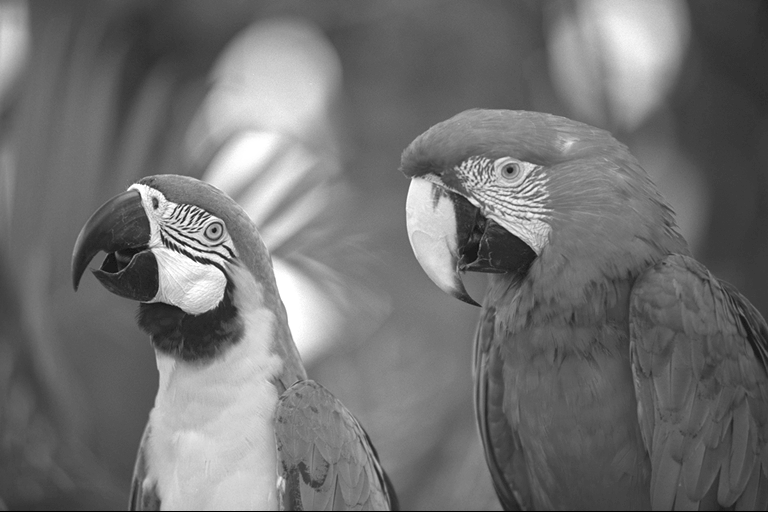

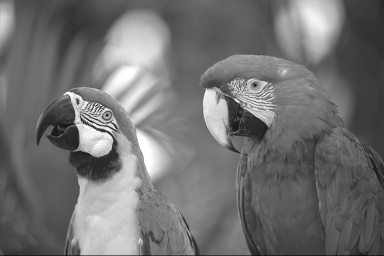

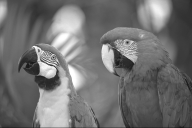

In [ ]:
G_pyr = gaussian_pyramid(image, J)
for level in range(J):
    cv2_imshow(G_pyr[level])

The Laplacian pyramid image for J = 3:

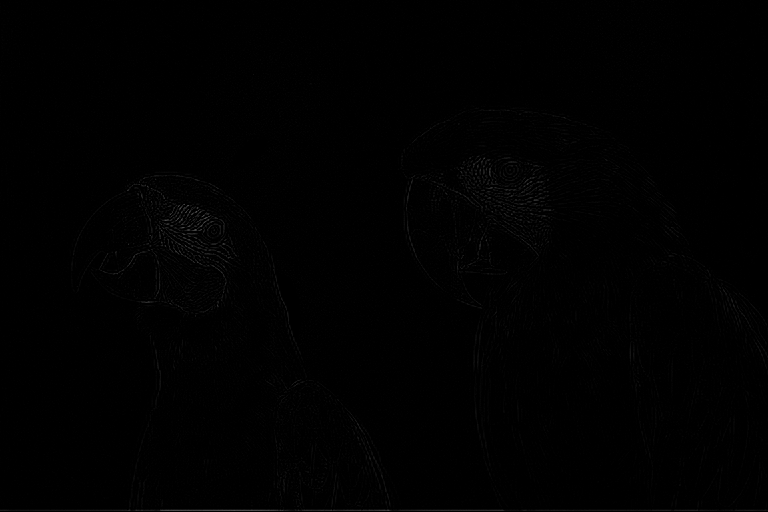

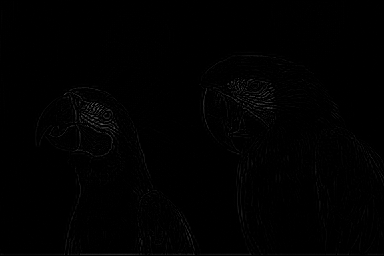

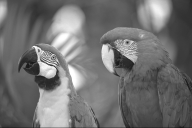

In [ ]:
L_pyr = laplacian_pyramid(image, J)
for level in range(J):
    cv2_imshow(L_pyr[level])

The reconstructed image from the Laplacian pyramid for J = 3:

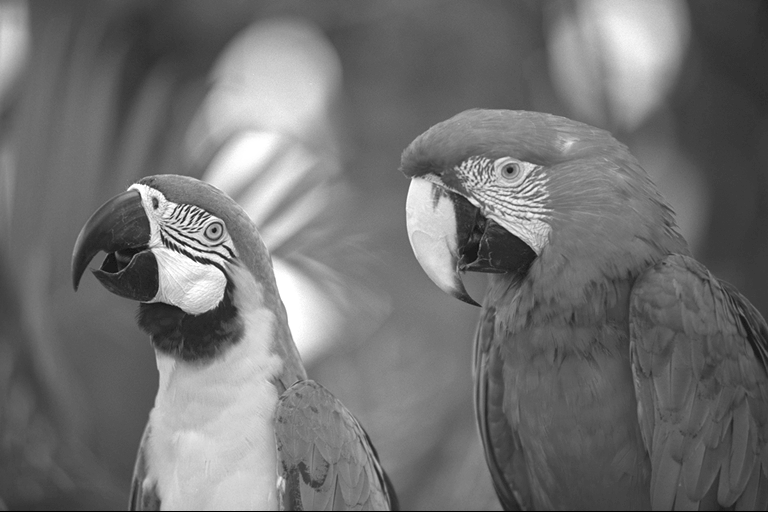

In [ ]:
reconstructed_image = reconstruct_laplacian(L_pyr)
cv2_imshow(reconstructed_image)

#### c) function to takes in a Laplacian pyramid and quantizes the coefficients c with quantization step-size q

In [ ]:
def quantize_pyramid(image, Q, J):

    lp = laplacian_pyramid(image, J)
    num_nonzero = 0

    # Quantization parameters: For the top level, mean = 128, for the other levels, mean = 0
    mean = [0] * J
    mean[-1] = 128
    quantized_lp = lp.copy()

    for level in range(J):
        quantized_lp[level] = np.floor((lp[level] - mean[level] + Q / 2) / Q) * Q + mean[level]
        num_nonzero += np.count_nonzero(quantized_lp[level])

    reconstructed_quant = reconstruct_laplacian(quantized_lp)

    return reconstructed_quant, num_nonzero

### d) Plotting the reconstruction PSNR:

In [ ]:
def plot_PSNR(image, n, J):
  rec_quant = np.zeros([n, image.shape[0], image.shape[1]])
  num = np.zeros(n)
  Q = np.zeros(n)
  psnr = np.zeros(n)

  _,ax = plt.subplots(n+1,1,figsize=(5, 60))

  for i in range(n):
    Q[i] = 2**i
    rec_quant[i], num[i] = quantize_pyramid(image, Q[i], J)
    mse = np.mean((rec_quant[i] - image[0]) ** 2)
    psnr[i] = 10 * np.log10(256 ** 2 / mse)
    ax[i].imshow(rec_quant[i],cmap='gray')
    ax[i].set_title('recovered image from quantize step = ' + str(i))

  ax[n].plot(psnr, num)
  plt.title('psnr vs number of non-zeros')
  plt.show()

J = 3 :

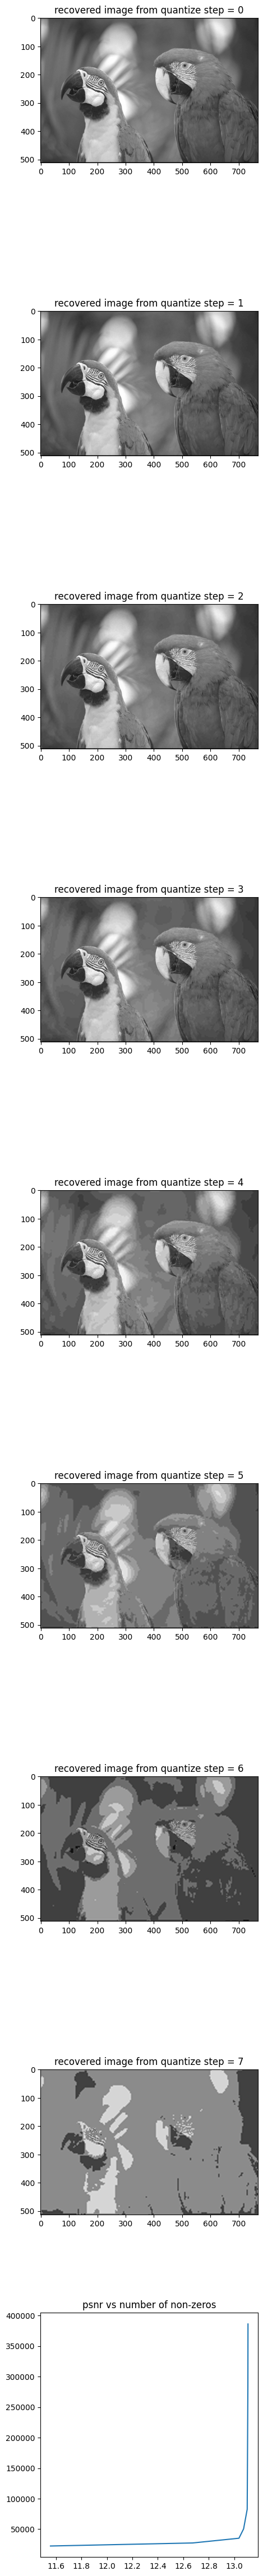

In [ ]:
n = 8
image = cv2.imread('/content/drive/MyDrive/CA01_images/color_image.png',0).astype(float)

J = 3
plot_PSNR(image, n, J)

J = 2:

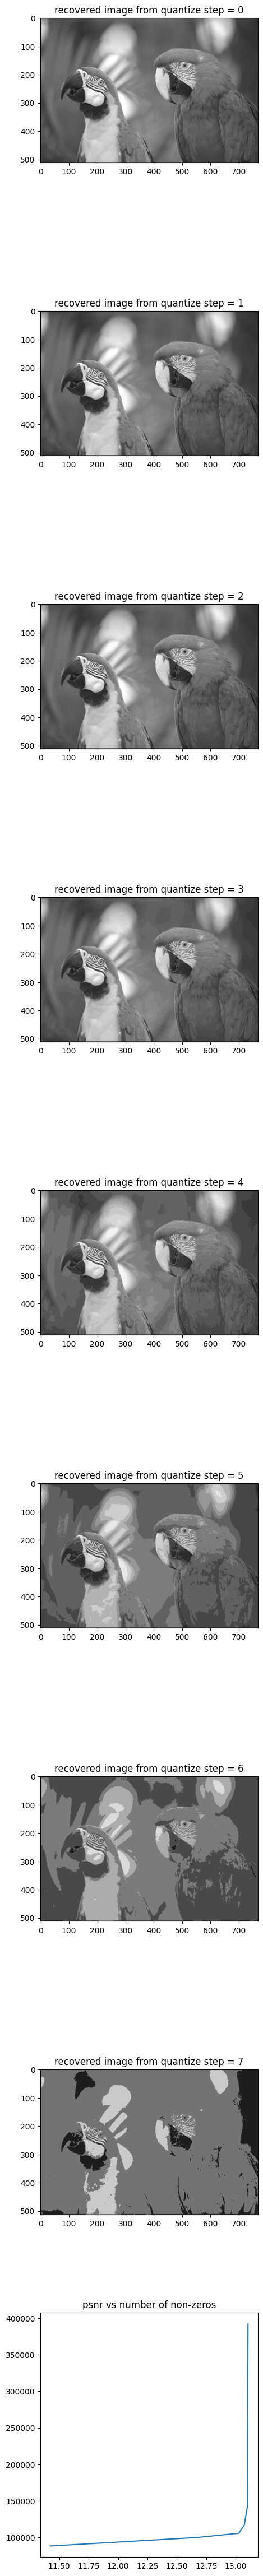

In [ ]:
J = 2
plot_PSNR(image, n, J)

J = 1:

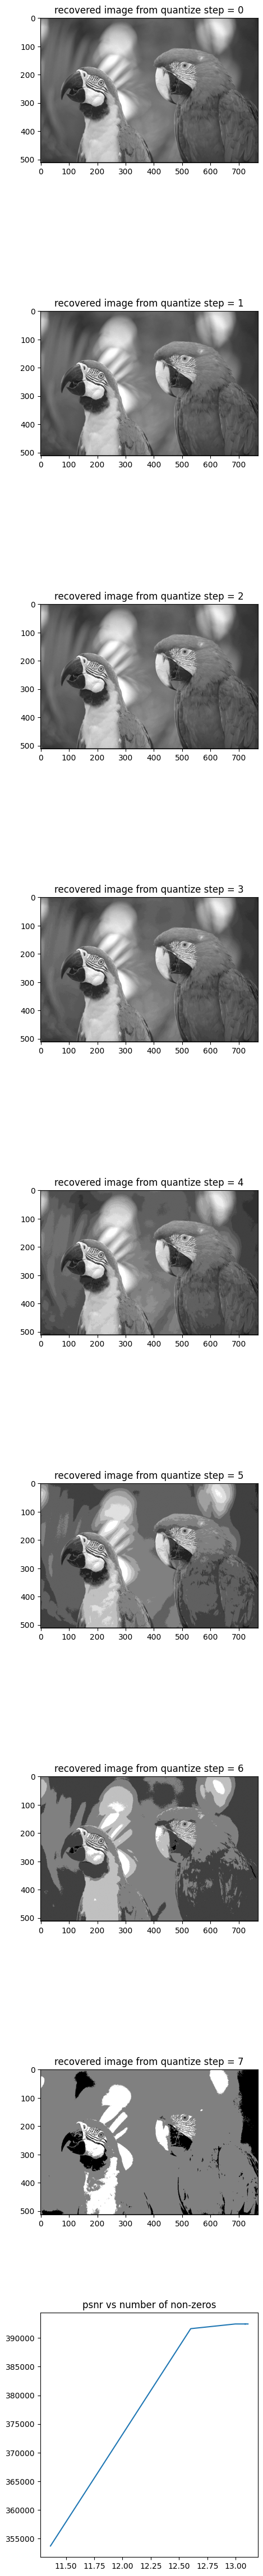

In [ ]:
J = 1
plot_PSNR(image, n, J)

The relationship between pyramid depth and representation efficiency for a desired reconstruction PSNR:


As we increase the depth of the pyramid, we create a more detailed representation of the original image, which can improve the ability to capture more details in the image.


The desired reconstruction PSNR is a measure of the quality of the reconstructed image. A high PSNR, means a reconstruction that closely matches the original image. So, for a desired reconstruction PSNR, a deeper pyramid can be more efficient in preserving details and achieving a higher level of quality in the reconstructed image, however, it also requires more data storage for the pyramid levels. Deeper pyramids can consume more memory and may be computationally expensive.

### e)

The point at which quantization becomes unnoticeable is the point where the reconstructed image closely resembles the original image. At this point, the number of non-zero coefficients is significantly reduced compared to the original image.

By comparing the reconstructed image with the original image, at a quantization level of Q = 3, we notice that the difference between the reconstructed image and the original image becomes insignificant, and this is the point at which quantization is unnoticeable.

At this point, the number of non-zero coefficients are significantly lower than the original image.